In [1]:
#  Professional Masters in Big Data Program - Simon Fraser University

#  Assignment 2 (Question 2)

#  Submission Date: 27th January 2019
#  Name: Anurag Bejju
#  Student ID: 301369375

In [41]:
#Importing all neccesary libraries used in this task
%matplotlib inline
import findspark
findspark.init()
import pyspark
from pyspark import SparkConf, SparkContext, SQLContext
conf = SparkConf().setAppName('Assignment 3')
sc = SparkContext(conf=conf)
spark = SQLContext(sc)
assert sys.version_info >= (3, 5)

from pyspark.sql import SparkSession, functions, types
import pyspark.sql.functions as F

from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import dayofyear,to_date,date_format,lit
from pyspark.ml.feature import StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline

from mpl_toolkits.basemap import Basemap, interp
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.mlab import griddata
import matplotlib as mpl
from matplotlib.colors import Normalize

import elevation_grid as eg

import pandas as pd
import numpy as np
from datetime import datetime
import sys

In [99]:
#Task 1: Calculating the Global Temperature Change between [1817 - 1917] and [1917 - 2017] 

tmax_schema = types.StructType([
    types.StructField('station', types.StringType()),
    types.StructField('date', types.DateType()),
    types.StructField('latitude', types.FloatType()),
    types.StructField('longitude', types.FloatType()),
    types.StructField('elevation', types.FloatType()),
    types.StructField('tmax', types.FloatType()),
])

if __name__ == "__main__":
    inputs = 'tmax-2'
    resultDF = spark.read.csv(inputs, schema=tmax_schema)
    
    # Two dataframes in temperature range [1817 - 1917] and [1917 - 2017]
    df1 = resultDF.filter((resultDF.tmax.isNotNull()) & (resultDF.date >= '1917-01-01'))
    df2 = resultDF.filter((resultDF.tmax.isNotNull()) & (resultDF.date < '1917-01-01') \
                          & (resultDF.date >= '1817-01-01'))
    
    # Getting one max temperature for each temperature range [1817 - 1917] and [1917 - 2017] for one station
    df1 = df1.groupBy('station','latitude','longitude').agg(functions.max('tmax'))\
                                            .withColumnRenamed("max(tmax)", "tmax_19")
    df2 = df2.groupBy('station','latitude','longitude').agg(functions.max('tmax'))\
                                        .withColumnRenamed("max(tmax)", "tmax_18")
    weather_joined = df1.join(df2, ((df1['latitude'] == df2['latitude']) & (df1['longitude'] == df2['longitude']) \
                                    & (df1['station'] == df2['station']) )).drop(df1.latitude) \
                                    .drop(df1.longitude).drop(df1.station)
    
    # Calculating the Global Temperature Change
    weather_df = weather_joined.withColumn("temperature_diff", weather_joined.tmax_19 -  weather_joined.tmax_18)
    
    # Grouping the temperature 
    df = weather_df.withColumn("temperature_group", F.floor(weather_df.temperature_diff))
    df = df.select('station','latitude','longitude','temperature_diff','temperature_group')
    df = df.toPandas()

In [100]:
# Reading a file with output of Task 1
tmax_schema = types.StructType([
    types.StructField('station', types.StringType()),
    types.StructField('latitude', types.FloatType()),
    types.StructField('longitude', types.FloatType()),
    types.StructField('temperature_diff', types.FloatType()),
])

if __name__ == "__main__":
    df = spark.read.csv('tmax-4', schema=tmax_schema)
    df = df.withColumn("temperature_group", F.floor(df.temperature_diff))
    df = df.toPandas()

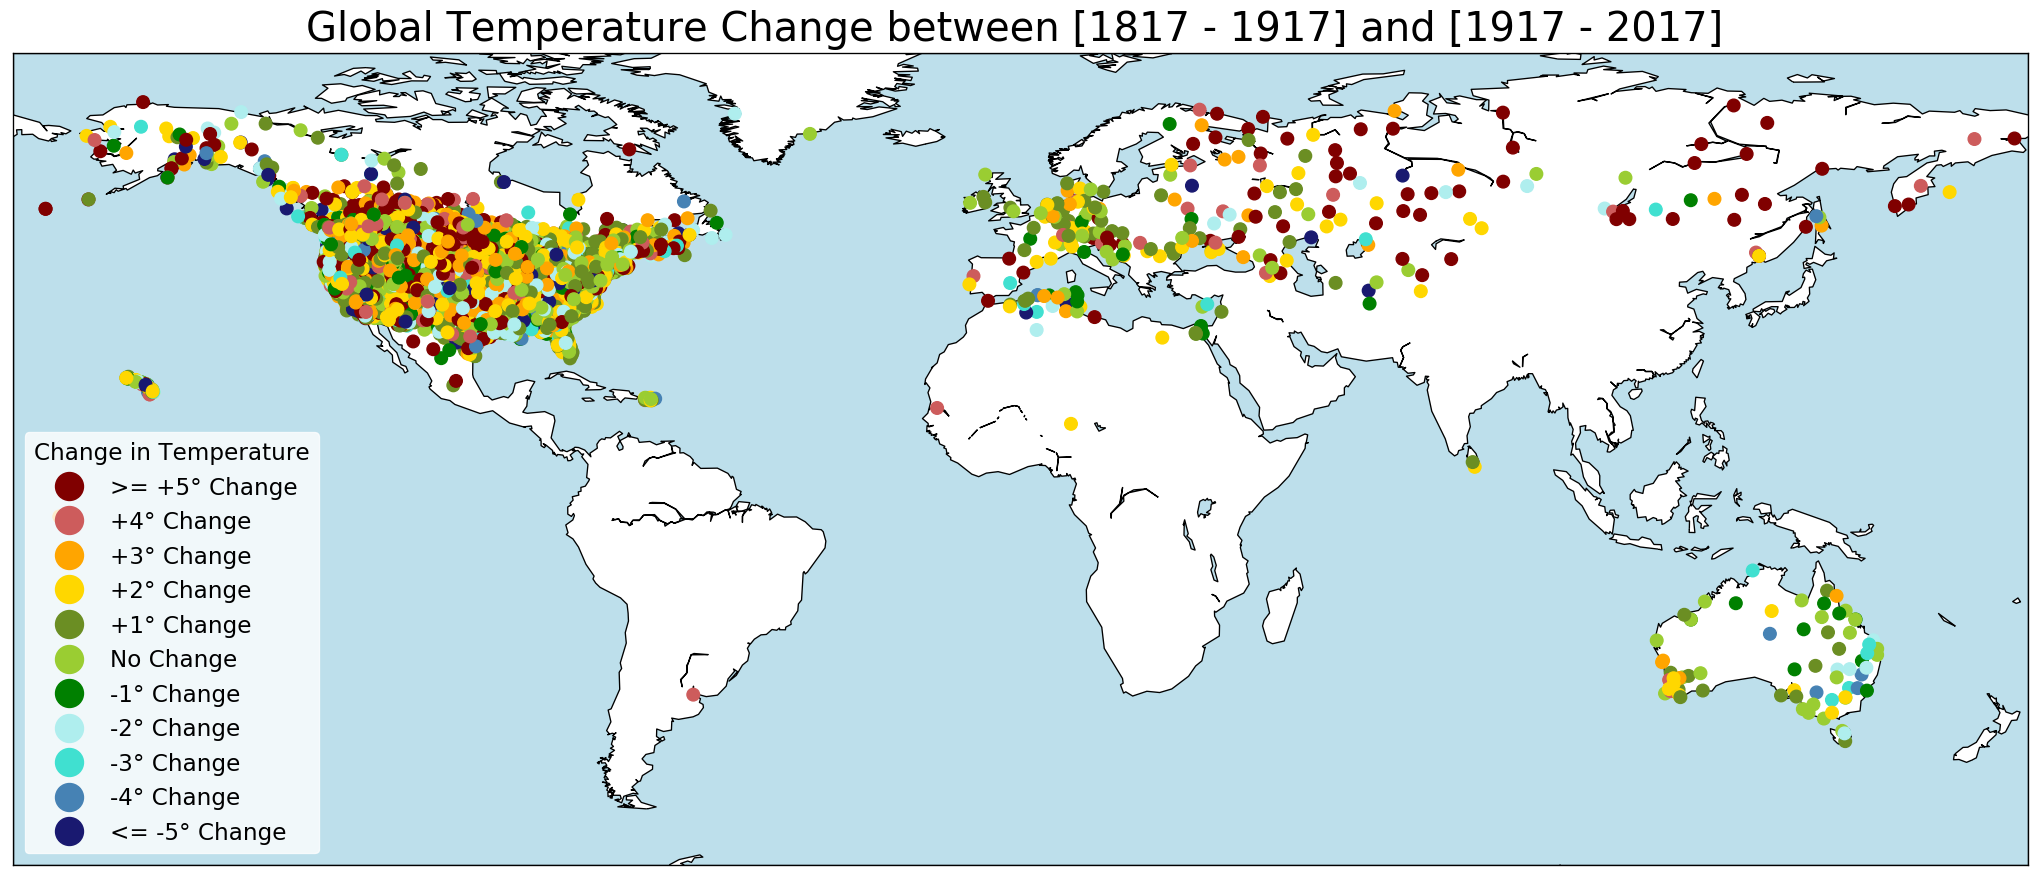

In [101]:
# Task 2 - A -> Visualization for max. temperature distribution over the entire globe

# Set the dimension of the figure
my_dpi=96
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)

# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#bddfeb', linewidth=1)
m.fillcontinents(color='#ffffff',alpha=1)
m.drawcoastlines()


color_dictionary = {5 : 'maroon',4 : 'indianred',3 : 'orange',2 : 'gold',1 : 'olivedrab',\
                    0 : 'yellowgreen',-1 : 'green', -2 : 'paleturquoise', \
                    -3 : 'turquoise',-4 : 'steelblue',-5 : 'midnightblue'}
labels = ['>= +5° Change','+4° Change','+3° Change','+2° Change','+1° Change',\
          'No Change', '-1° Change', '-2° Change','-3° Change','-4° Change', '<= -5° Change']

# Color Group
def set_colour(temp_change):
    if temp_change < -5:
        return color_dictionary[-5]
    elif temp_change > 5:
        return color_dictionary[5]
    else:
        return color_dictionary[temp_change]
    pass

# Setting a color for each temperature group
df['color'] = df.apply (lambda row: set_colour(row.temperature_group),axis=1)

plt.title("Global Temperature Change between [1817 - 1917] and [1917 - 2017] ",fontdict={'fontsize': 30,\
                                                            'fontweight' : 10},  loc='center',pad =10)

# Add a point per position
m.scatter(df['longitude'], df['latitude'], s=90, linewidth=1, c=df['color'], cmap="Set1",zorder=10)
markers = [plt.Line2D([0,0],[0,0],color=color,  marker='o', linestyle='',zorder=20) for color in my_dict.values()]

# Put a legend to the right of the current axis
legend = plt.legend(markers, labels, numpoints=1, loc=3,  fontsize="xx-large", markerscale=3.5,\
                    facecolor="white",edgecolor="white",title="Change in Temperature")
plt.setp(legend.get_title(),fontsize='xx-large')
legend.set_zorder(20)

# Save as png
plt.savefig('Global_Temperature_Change.png', bbox_inches='tight')

In [102]:
# Task 2 - B1:

# Training Model

tmax_schema = types.StructType([
    types.StructField('station', types.StringType()),
    types.StructField('date', types.DateType()),
    types.StructField('latitude', types.FloatType()),
    types.StructField('longitude', types.FloatType()),
    types.StructField('elevation', types.FloatType()),
    types.StructField('tmax', types.FloatType()),
])


def train_model(model_file, inputs):

    # Read the CSV File
    test_tmax = spark.read.csv(inputs, schema=tmax_schema)

    # Split the dataset. Make 75% as training set and the remaining 25% as validation set
    train, validation = test_tmax.randomSplit([0.75, 0.25])
    train = train.cache()
    validation = validation.cache()

    # SQL Query having no yesterday tmax
    query_without_yesterday = "SELECT DAYOFYEAR(today.date) as day_of_year, today.longitude,\
                                    today.latitude,today.elevation,today.tmax,today.station FROM __THIS__ as today"
    sqlTrans_without_yesterday = SQLTransformer(statement=query_without_yesterday)

    # Feature assembler not considering yesterday_tmax as a feature
    feature_assembler_without_yesterday = VectorAssembler(inputCols=["latitude", "longitude", "elevation",\
                                                                     "day_of_year"], outputCol="features")
    
    # Using GBTRegressor
    word_indexer = StringIndexer(inputCol="station", outputCol="label", handleInvalid='error')
    estimator = GBTRegressor(featuresCol = 'features', labelCol = 'tmax', maxIter = 100)

    # Create pipelines for models being made with and without yesterday_tmax feature
    feature_pipeline_without_yesterday = Pipeline(stages=[sqlTrans_without_yesterday,\
                                            feature_assembler_without_yesterday,word_indexer,estimator])
   
    # Training models with and without yesterday_tmax feature
    model_without_yesterday = feature_pipeline_without_yesterday.fit(train)
    
    # use the model to make predictions
    predictions_without_yesterday = model_without_yesterday.transform(validation)

    # evaluate the predictions without yesterday_tmax as a feature
    r2_evaluator_without_yesterday = RegressionEvaluator(predictionCol='prediction', labelCol='tmax',metricName='r2')
    r2_without_yesterday = r2_evaluator_without_yesterday.evaluate(predictions_without_yesterday)

    rmse_evaluator_without_yesterday = RegressionEvaluator(predictionCol='prediction', labelCol='tmax',\
                                                           metricName='rmse')
    rmse_without_yesterday = rmse_evaluator_without_yesterday.evaluate(predictions_without_yesterday)


    # r^2 and rmse values for models not considering yesterday_tmax as a feature
    print('r2 without yesterday tmax as a feature =', r2_without_yesterday)
    print('rmse without yesterday tmax as a feature =', rmse_without_yesterday)

    # save model considering yesterday_tmax as a feature
    model_without_yesterday.write().overwrite().save(model_file)


if __name__ == '__main__':
    inputs = 'tmax-2'
    model_file = 'model'
    train_model(model_file, inputs)

r2 without yesterday tmax as a feature = 0.834406633956559
rmse without yesterday tmax as a feature = 5.2587268995368825


In [103]:
#Testing function that inputs pretrained model and dataframe
#It outputs predicted temperature values

def test_model(test_tmax,model_file):

    # load the model
    model = PipelineModel.load(model_file)

    # use the model to make predictions
    predictions = model.transform(test_tmax)
    prediction_values = predictions.filter((predictions.day_of_year >= 1) & (predictions.day_of_year <= 31))
    prediction_values = prediction_values.select("station","longitude","latitude","elevation","day_of_year",\
                                                 "tmax","prediction")
    prediction_values = prediction_values.filter((prediction_values.longitude.isNotNull()) & \
                                                 (prediction_values.latitude.isNotNull()))
    prediction_values = prediction_values.withColumn("regression_error", \
                                                     F.floor(prediction_values.prediction -  prediction_values.tmax))
    df = prediction_values.toPandas()
    return df



In [104]:
# Creating a test dataset containing longitude, latitude and elevation spanning over the entire globe

tmax_schema = types.StructType([
    types.StructField('station', types.StringType()),
    types.StructField('longitude', types.FloatType()),
    types.StructField('latitude', types.FloatType()),
    types.StructField('elevation', types.FloatType()),
    types.StructField('tmax', types.FloatType()),
])

# Getting longitude, latitude and elevation
lons, lats = np.meshgrid(np.arange(-180,180,1.0),np.arange(-90,90,1.0))
elevs = [eg.get_elevations(np.array([late,lone]).T) for late,lone in zip(lats,lons)]

# Converting above longitude, latitude and elevation values to datagfram
test_dataset = pd.DataFrame({"station":'SFU00001','longitude': lons.flatten().tolist(), \
                             'latitude': lats.flatten().tolist(), \
                             'elevation': np.asarray(elevs, dtype=np.float32).flatten().tolist(),\
                             'tmax':0.0}, columns=["station",'longitude', 'latitude','elevation','tmax'])

# Convert to spark dataframe
df = spark.createDataFrame(test_dataset,schema=tmax_schema)

# Add date column
test_tmax = df.withColumn('date',lit(datetime.strptime('2019-01-01', '%Y-%m-%d').date()))
model_file = 'model'

# Pass the newly created dataframe to testing function to get the prediction values
task2_df = test_model(test_tmax,model_file)
    

<Figure size 432x288 with 0 Axes>

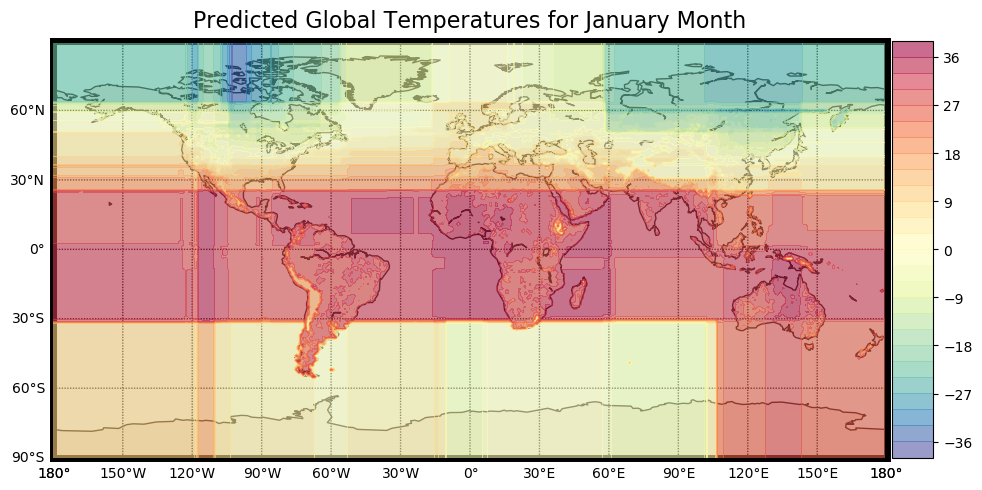

In [105]:
# Task 2 - B1 -> Visualization for predicted temperatures using grid of latitude, longitude positions around the 
#               globe spanning across oceans and continents, leading to a dense plot of temperatures

mpl.rcParams['figure.figsize'] = (10, 10)
get_ipython().magic(u'matplotlib inline')

# set up Basemap instance
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180,resolution='c')

lons, lats = np.meshgrid(np.arange(-180,180,1.0),np.arange(-90,90,1.0))
shape = lons.shape
pred_temp = task2_df['prediction'].values.reshape(shape)

# set up plot
plt.clf()
dpi = 100
fig = plt.figure(figsize=(1100/dpi, 1100/dpi), dpi=dpi)
ax  = fig.add_axes([0.1,0.1,0.8,0.9])

# Add plot title
plt.title("Predicted Global Temperatures for January Month",fontdict={'fontsize': 16,
 'fontweight' : 10},  loc='center',pad =10)

# draw coastlines, state and country boundaries, edge of map
m.drawmapboundary(fill_color='#d6ebf2', linewidth=5)
m.fillcontinents(alpha=0.6)
m.drawcoastlines()

# create and draw meridians and parallels grid lines
m.drawparallels(np.arange( -90., 90.,30),labels=[1,0,0,0],fontsize=10)
m.drawmeridians(np.arange(-180.,180.,30),labels=[0,0,0,1],fontsize=10)

# contour plots
#con = m.contour(xi, yi, zi, 20, zorder=10, linewidths=.25, colors='k', alpha=0.6,cmap=cmap)
conf = m.contourf(lons,lats, pred_temp, 25, zorder=10, alpha=0.6, cmap='Spectral_r')
#plt.pcolormesh(lons,lats,pred_temp,cmap='Spectral_r',zorder=10, alpha=0.4,linewidth=0,rasterized=True)

# add colour bar, title, and scale
cbar = m.colorbar( fraction=.057, pad=0.05)

plt.savefig("Predicted_Global_Temperature.png", format="png", transparent=True, dpi=300)
plt.show()

In [106]:
# Task 2 - B2: plot the regression error of model predictions against test data


tmax_schema = types.StructType([
    types.StructField('station', types.StringType()),
    types.StructField('date', types.DateType()),
    types.StructField('latitude', types.FloatType()),
    types.StructField('longitude', types.FloatType()),
    types.StructField('elevation', types.FloatType()),
    types.StructField('tmax', types.FloatType()),
])

inputs = 'tmax-test'
model_file = 'model'
test_tmax_2 = spark.read.csv(inputs, schema=tmax_schema)

# get model predictions against test data 
df = test_model(test_tmax_2,model_file)

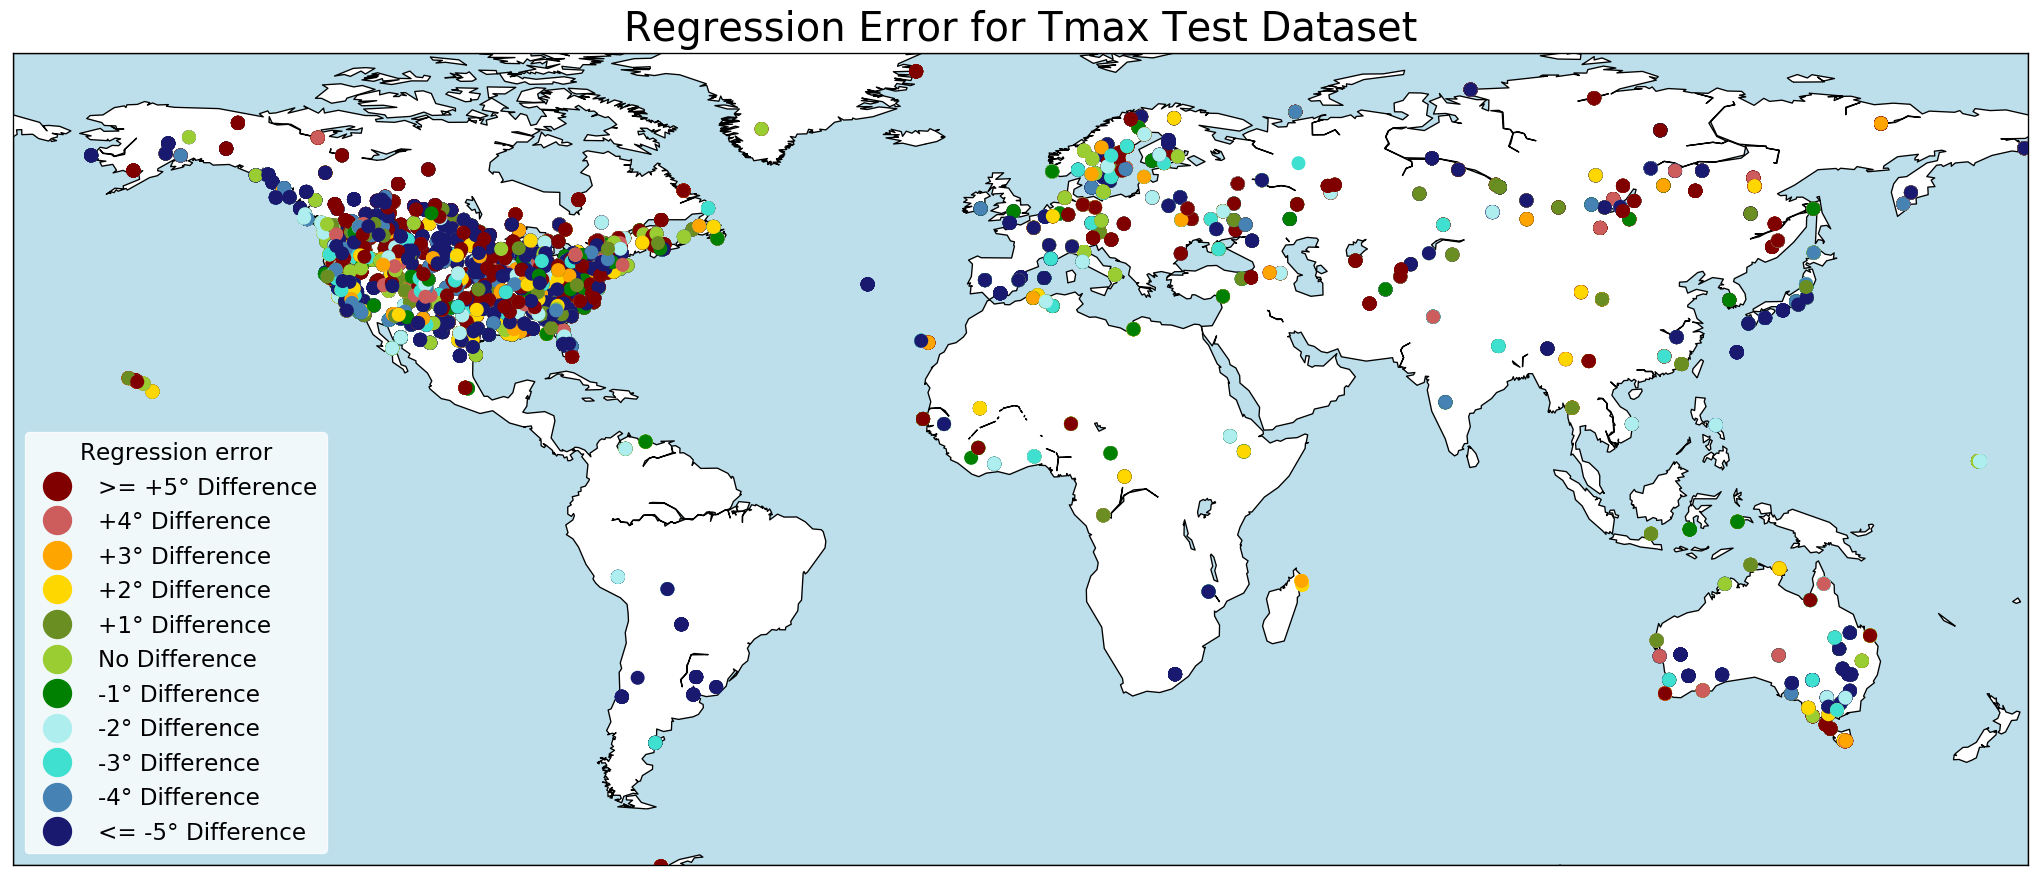

In [107]:
# Task 2 - B2: Visualization to plot the regression error of model predictions against test data
# Set the dimension of the figure
my_dpi=96
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)

# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#bddfeb', linewidth=1)
m.fillcontinents(color='#ffffff',alpha=1)
m.drawcoastlines()


color_dictionary = {5 : 'maroon',4 : 'indianred',3 : 'orange',2 : 'gold',1 : 'olivedrab',\
                    0 : 'yellowgreen',-1 : 'green', -2 : 'paleturquoise', -3 : 'turquoise',\
                    -4 : 'steelblue',-5 : 'midnightblue'}
labels = ['>= +5° Difference','+4° Difference','+3° Difference','+2° Difference',\
          '+1° Difference','No Difference', '-1° Difference', '-2° Difference','-3° Difference',\
          '-4° Difference', '<= -5° Difference']

# Color Group
def set_colour(temp_change):
    if temp_change < -5:
        return color_dictionary[-5]
    elif temp_change > 5:
        return color_dictionary[5]
    else:
        return color_dictionary[temp_change]
    pass

# Setting a color for each regression_error difference
df['color'] = df.apply (lambda row: set_colour(row.regression_error),axis=1)

plt.title("Regression Error for Tmax Test Dataset",fontdict={'fontsize': 30,\
                                                            'fontweight' : 10},  loc='center',pad =10)

# Add a point per position
m.scatter(df['longitude'], df['latitude'], s=90, linewidth=1, c=df['color'], cmap="Set1",zorder=10)
markers = [plt.Line2D([0,0],[0,0],color=color,  marker='o', linestyle='',zorder=20) for color in my_dict.values()]

# Put a legend to the right of the current axis
legend = plt.legend(markers, labels, numpoints=1, loc=3,  fontsize="xx-large", markerscale=3.5,\
                    facecolor="white",edgecolor="white",title="Regression error")
plt.setp(legend.get_title(),fontsize='xx-large')
legend.set_zorder(20)

# Save as png
plt.savefig('Regression_Error.png', bbox_inches='tight')

In [40]:
sc.stop()